In [112]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [113]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD, FastLogisticSVD
from RecData import RecData

In [114]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
279261,271590,True,2706940
968812,698540,True,3892918
965466,1085510,True,4590796
965540,1949960,False,3058171
1373726,1088850,True,2018014


In [115]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 4.539058446884155 seconds


In [116]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [117]:
del item_data
del titles

Epoch 0/Training error: 0.6931417827830794/Validation error: 0.6931459793074225/Time: 3.49 seconds
Epoch 1/Training error: 0.6931367446132077/Validation error: 0.6931459769787571/Time: 3.58 seconds
Epoch 2/Training error: 0.6931316827643351/Validation error: 0.6931459672798528/Time: 3.63 seconds
Epoch 3/Training error: 0.693126584191733/Validation error: 0.6931459475790287/Time: 3.52 seconds
Epoch 4/Training error: 0.6931214367708757/Validation error: 0.6931459154946147/Time: 3.5 seconds
Epoch 5/Training error: 0.6931162270032972/Validation error: 0.6931458679019982/Time: 3.51 seconds
Epoch 6/Training error: 0.6931109418088192/Validation error: 0.693145801801855/Time: 3.48 seconds
Epoch 7/Training error: 0.693105566344764/Validation error: 0.6931457136529464/Time: 3.48 seconds
Epoch 8/Training error: 0.6931000858769943/Validation error: 0.6931455994265816/Time: 3.49 seconds
Epoch 9/Training error: 0.6930944846485969/Validation error: 0.6931454548999597/Time: 3.51 seconds
Epoch 10/Train

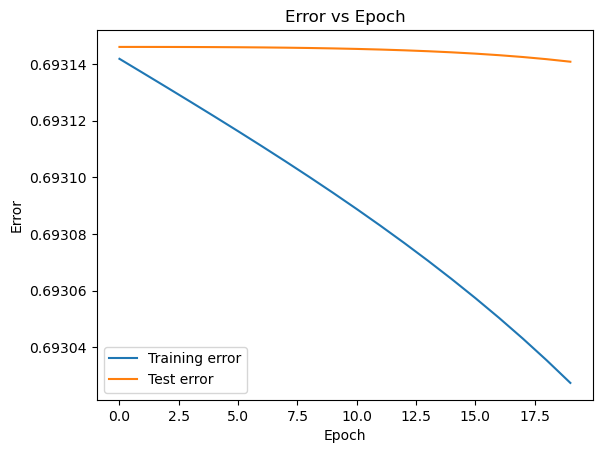

Test rmse 0.49999678950638005


In [118]:
EPOCHS = 20 #240

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
    learning_rate=0.001, C=0)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [294]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training error: 0.2535816581955625/Validation error: 0.4076673854244329/Time: 3.55 seconds
Epoch 1/Training error: 0.25240810644000056/Validation error: 0.4076605676177521/Time: 3.56 seconds
Epoch 2/Training error: 0.25123972191014476/Validation error: 0.40765923585690955/Time: 3.53 seconds
Epoch 3/Training error: 0.25007639532235615/Validation error: 0.40766175882561945/Time: 3.58 seconds
Epoch 4/Training error: 0.2489181371600925/Validation error: 0.40766877522805134/Time: 3.53 seconds
Epoch 5/Training error: 0.24776489126494133/Validation error: 0.40767860168427605/Time: 3.54 seconds
Epoch 6/Training error: 0.24661667828423686/Validation error: 0.4076935576449632/Time: 3.55 seconds
Epoch 7/Training error: 0.24547344429952564/Validation error: 0.40771325534896885/Time: 3.53 seconds
Epoch 8/Training error: 0.24433518057128495/Validation error: 0.40773669443911414/Time: 3.54 seconds
Epoch 9/Training error: 0.24320182170687676/Validation error: 0.4077640966347777/Time: 3.54 seco

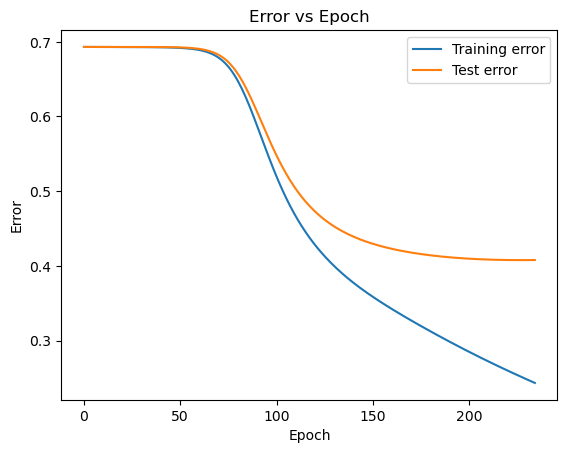

Test rmse 0.35594073495938466


In [295]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

In [299]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([rec_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


In [297]:
j = 0
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.9998819707294742, 'Wallpaper Engine'),
 (0.9995590787694483, 'Left 4 Dead 2'),
 (0.9994935727705616, 'Divinity: Original Sin 2 - Definitive Edition'),
 (0.9994683354223289, 'Portal'),
 (0.9992953110985962, 'Half-Life: Alyx'),
 (0.9992238676640842, "Garry's Mod"),
 (0.9992214162308917, 'Resident Evil 2'),
 (0.9991994841586249, 'Slay the Spire'),
 (0.9990981897369617, 'Dishonored'),
 (0.9990803125428781, 'The Binding of Isaac: Rebirth'),
 (0.9990272249115129, 'Satisfactory'),
 (0.9989514454571355, 'Vampire Survivors'),
 (0.9989267441437243, 'Portal 2'),
 (0.998826499219789, 'RimWorld'),
 (0.9987650489868525, 'ULTRAKILL'),
 (0.9987639876448442, 'Resident Evil Village'),
 (0.9986522758458294, 'Factorio'),
 (0.9986490380341819, 'The Witcher® 3: Wild Hunt'),
 (0.998614903242855, 'Papers Please'),
 (0.9985244968637511, 'Terraria')]
True top n:
['Grand Theft Auto V',
 'Wallpaper Engine',
 'Counter-Strike: Global Offensive',
 'Undertale',
 'Sid Meier’s Civilization® VI',
 '

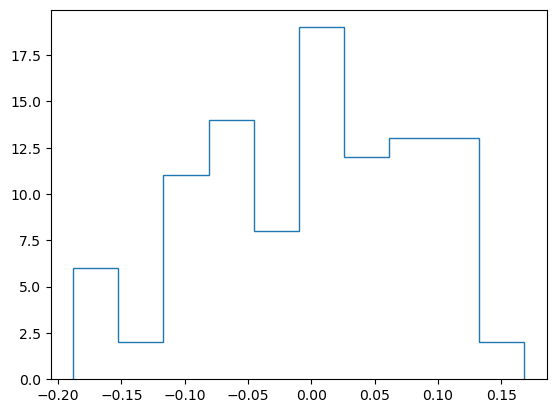

In [298]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [303]:
rec_data.search_title('sims')

[('The Sims™ 4', 59), ('The Sims™ 3', 342)]

In [304]:
prefs = [(1045, 0), (59, 1), (342, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(1045, 'Mortal Kombat X', 0), (59, 'The Sims™ 4', 1), (342, 'The Sims™ 3', 1)]


In [305]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 2.78 seconds
Epoch 1/Time: 2.78 seconds
Epoch 2/Time: 2.78 seconds
Epoch 3/Time: 2.79 seconds
Epoch 4/Time: 2.79 seconds
Epoch 5/Time: 2.83 seconds
Epoch 6/Time: 2.82 seconds
Epoch 7/Time: 2.79 seconds
Epoch 8/Time: 2.79 seconds
Epoch 9/Time: 3.25 seconds
Epoch 10/Time: 3.02 seconds
Epoch 11/Time: 2.94 seconds
Epoch 12/Time: 2.84 seconds
Epoch 13/Time: 2.83 seconds
Epoch 14/Time: 2.83 seconds
Epoch 15/Time: 2.83 seconds
Epoch 16/Time: 2.85 seconds
Epoch 17/Time: 2.84 seconds
Epoch 18/Time: 2.86 seconds
Epoch 19/Time: 2.81 seconds
Completed partial fit in 58.161810636520386 seconds


In [306]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.6255425448245089, 'Fallout 4'),
 (0.5949545797820359, "No Man's Sky"),
 (0.5762997469003915, 'Just Cause™ 3'),
 (0.5732127184248318, 'Wallpaper Engine'),
 (0.5721954095739206, 'Killing Floor 2'),
 (0.5683118255318348, 'Borderlands 3'),
 (0.5660601587888737, 'Rust'),
 (0.5589130697537803, 'Left 4 Dead 2'),
 (0.5576191196346886, 'Far Cry® 5'),
 (0.5553638694761791, 'Factorio'),
 (0.5549266431104046, "Garry's Mod"),
 (0.5538170737907843, 'Fallout 76'),
 (0.5536022498084484, 'Resident Evil 2'),
 (0.5526554432332553, 'Portal 2'),
 (0.5512152299977823, 'Portal'),
 (0.5508887634117217, 'Resident Evil Village'),
 (0.550689430205356, 'Risk of Rain 2'),
 (0.5504087964946794, 'Remnant: From the Ashes'),
 (0.5498160712366424, 'The Elder Scrolls® Online'),
 (0.5483481067192361, 'METAL GEAR RISING: REVENGEANCE')]
